In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)

## 1. Load Data & Features
We load the raw data and apply the *latest* feature engineering logic (Exp 17).

In [2]:
import src.features
import importlib
importlib.reload(src.features)
from src.features import extract_user_attributes, generate_training_data, aggregate_user_features

print("Loading Raw Data...")
train_df_raw = pd.read_parquet('../data/train.parquet')
test_df_raw = pd.read_parquet('../data/test.parquet')

print("Applying Feature Engineering (Exp 17)...")
# 1. Extract Attributes
train_df_raw = extract_user_attributes(train_df_raw)
test_df_raw = extract_user_attributes(test_df_raw)

# 2. Generate Training Data (Snapshots)
df_train = generate_training_data(train_df_raw)

# 3. Generate Test Data (Single Snapshot at End)
global_max_ts = test_df_raw['ts'].max()
test_snapshot_df = pd.DataFrame({
    'userId': test_df_raw['userId'].unique(),
    'cutoff_ts': global_max_ts
})
df_test = aggregate_user_features(test_df_raw, snapshot_df=test_snapshot_df)
df_test = df_test.reset_index(level='cutoff_ts', drop=True)

# Align Columns
cols_to_drop = ["target", "userId", "cutoff_ts"]
X_train = df_train.drop(columns=[c for c in cols_to_drop if c in df_train.columns])
X_test = df_test[X_train.columns]

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")

Loading Raw Data...
Applying Feature Engineering (Exp 17)...
Applying Feature Engineering (Exp 17)...
Generated 85807 snapshots.
Class Balance: 12.28%
Generated 85807 snapshots.
Class Balance: 12.28%
Train Shape: (85807, 40)
Test Shape: (2904, 40)
Train Shape: (85807, 40)
Test Shape: (2904, 40)


## 2. Covariate Shift Analysis
We compare the distribution of features in the Training Set (Snapshots) vs the Test Set (Full History).
Large divergences indicate "Toxic Features" that will confuse the model.

**Key Metric**: Mean Percentage Difference.
$$ \text{Diff} = \frac{\mu_{train} - \mu_{test}}{\mu_{train} + \epsilon} $$

Top 10 Most Divergent Features (Potential Toxicity):
                         mean_train  std_train  mean_test  std_test  \
log_errors_last_14d        0.106815   0.292508   0.223287  0.412793   
log_errors_last_30d        0.202135   0.401986   0.414621  0.543841   
log_errors_last_7d         0.058217   0.212426   0.118023  0.302849   
frustration_score          0.002208   0.008255   0.004419  0.010932   
log_songs_last_7d          2.002821   2.358454   3.637921  2.290284   
log_listen_time_last_7d    4.530782   4.988685   7.859341  4.461689   
errors_per_day             0.010064   0.019785   0.017272  0.056180   
log_songs_last_14d         2.807663   2.544698   4.724984  2.008520   
downgrade                  0.154614   0.361539   0.256543  0.436800   
trend_errors_7d_vs_30d     0.233247   0.870821   0.382000  1.023289   

                         mean_diff_pct  abs_diff_pct  
log_errors_last_14d          -1.090404      1.090404  
log_errors_last_30d          -1.051209      1.051209  


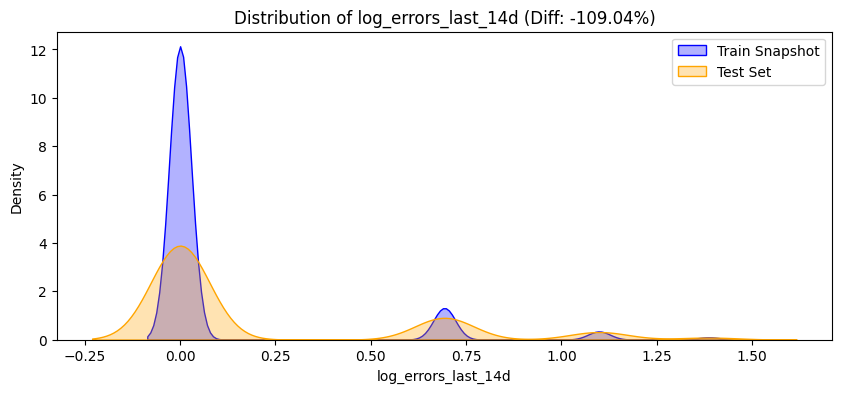

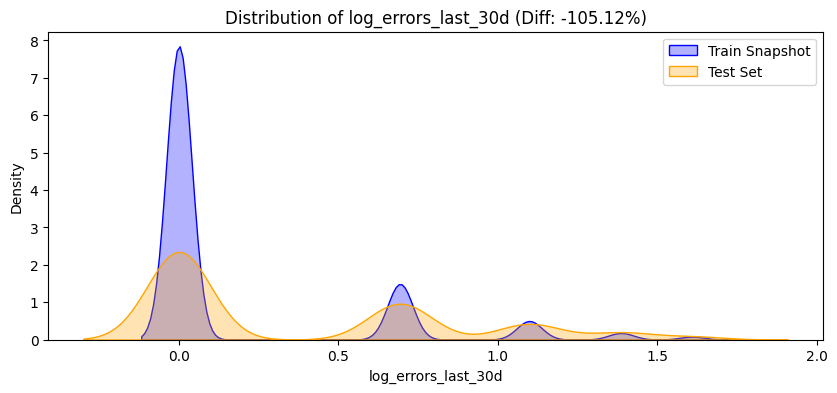

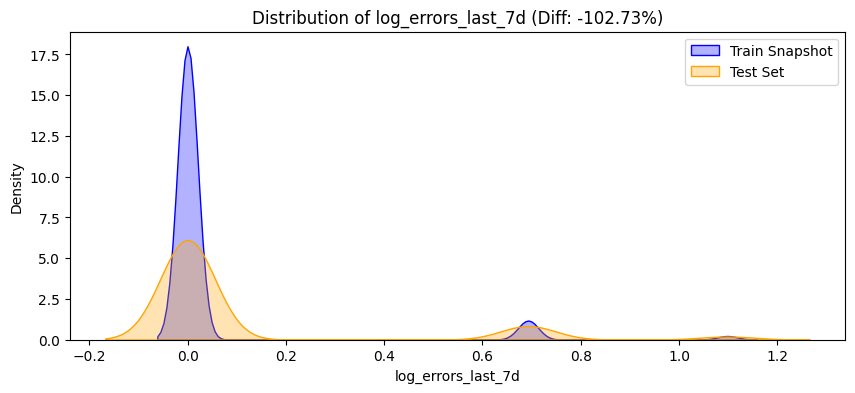

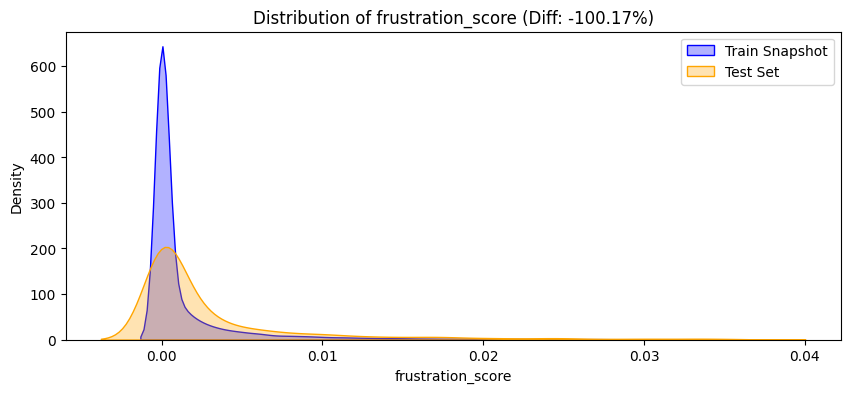

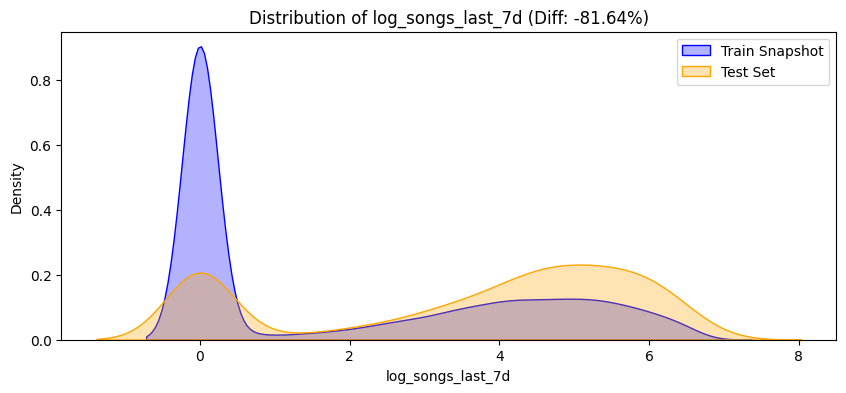

In [3]:
# Calculate Statistics
train_stats = X_train.describe().T[['mean', 'std']]
test_stats = X_test.describe().T[['mean', 'std']]

# Compare
comparison = train_stats.join(test_stats, lsuffix='_train', rsuffix='_test')
comparison['mean_diff_pct'] = (comparison['mean_train'] - comparison['mean_test']) / (comparison['mean_train'] + 1e-9)
comparison['abs_diff_pct'] = comparison['mean_diff_pct'].abs()

print("Top 10 Most Divergent Features (Potential Toxicity):")
print(comparison.sort_values(by='abs_diff_pct', ascending=False).head(10))

# Plot Top 5 Divergent Features
top_divergent = comparison.sort_values(by='abs_diff_pct', ascending=False).head(5).index.tolist()

for f in top_divergent:
    plt.figure(figsize=(10, 4))
    # Clip outliers for better visualization
    q99 = X_train[f].quantile(0.99)
    data_train = X_train[X_train[f] <= q99][f]
    data_test = X_test[X_test[f] <= q99][f]
    
    sns.kdeplot(data_train, label='Train Snapshot', fill=True, color='blue', alpha=0.3)
    sns.kdeplot(data_test, label='Test Set', fill=True, color='orange', alpha=0.3)
    plt.title(f"Distribution of {f} (Diff: {comparison.loc[f, 'mean_diff_pct']:.2%})")
    plt.legend()
    plt.show()

## 3. Feature Importance Analysis
We load the trained model (Last Exp) and analyze which features are driving the predictions.

📂 Loading artifacts...
📋 Loaded 39 backup feature names.

🔍 Analyzing Base Estimators...
   Processing: xgb...
   ⚠️  Patching missing feature name (likely 'exploration_rate').
   Processing: lgbm...
      🔧 Generic names detected for 'lgbm'. Attempting patch...
         ⚠️ Size Mismatch: Model has 40, Backup has 39.
         ✂️ TRIMMING the last 1 feature(s) from 'lgbm' to force alignment.
   Processing: cat...
   ⚠️  Patching missing feature name (likely 'exploration_rate').
   Processing: rf...
   ⚠️  Patching missing feature name (likely 'exploration_rate').
   Processing: bag_lr...

✅ Aggregation Complete (Top 10):
                               xgb      lgbm       cat        rf    bag_lr  \
log_listen_time_last_30d  0.720805  1.000000  1.000000  1.000000  0.243002   
log_errors_last_7d        1.000000  0.137667  0.062160  0.836379  0.676186   
downgrade                 0.117165  0.602294  0.277620  0.461025  0.968059   
log_listen_time_last_7d   0.340135  0.313576  0.169562  0.52

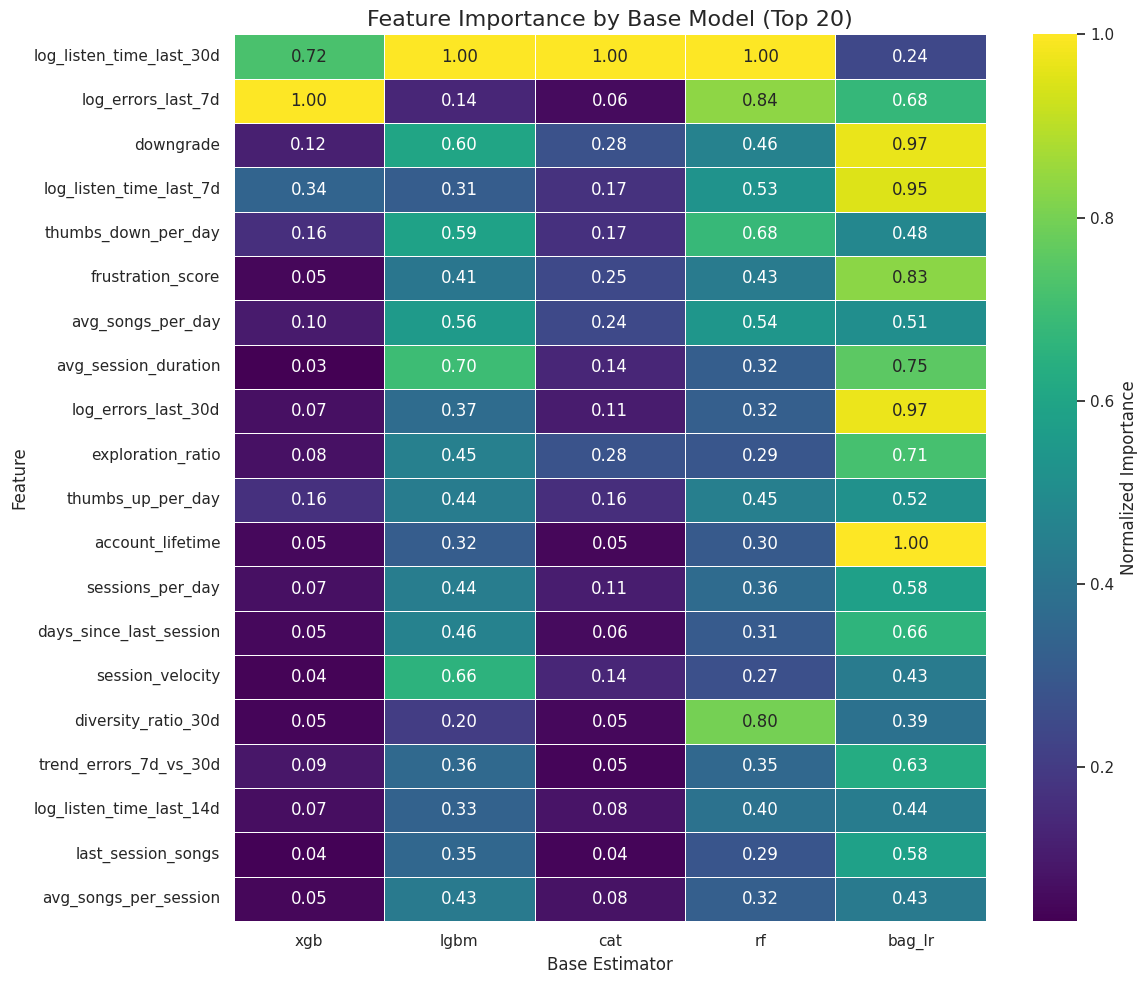

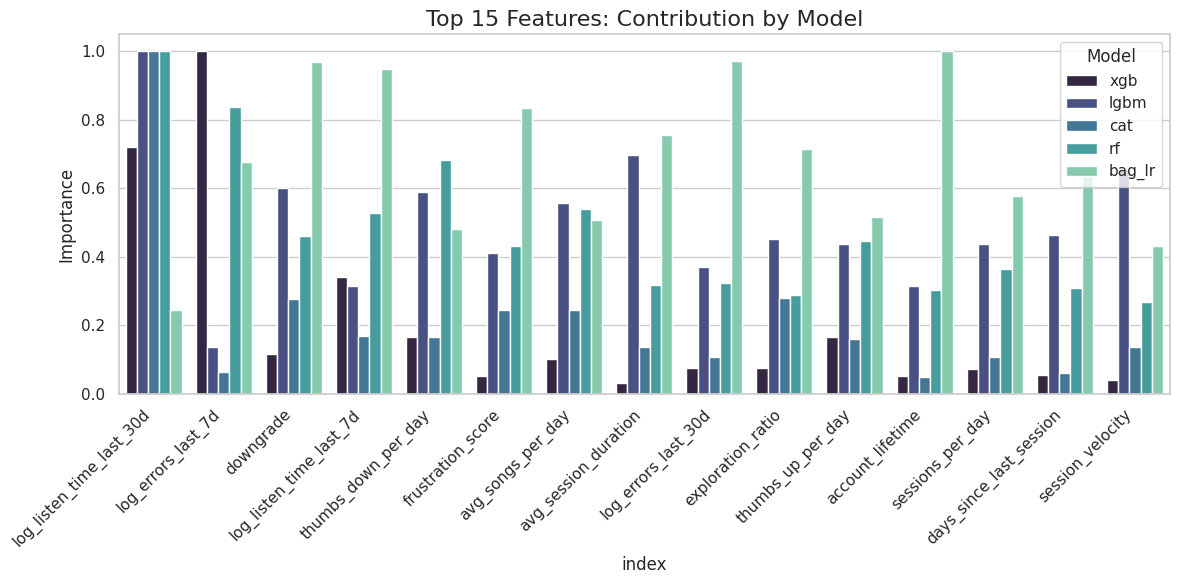

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import importlib

# RELOAD UTILS & VISUALIZATION
import src.utils as utils

importlib.reload(utils)
import src.visualization

importlib.reload(src.visualization)
from src.visualization import get_true_names_and_importance

MODELS_DIR = "../models"
MODEL_PATH = os.path.join(MODELS_DIR, "stacking_model.joblib")
FEATURES_PATH = os.path.join(MODELS_DIR, "feature_names.joblib")

sns.set_theme(style="whitegrid", context="notebook", palette="mako")

# --- MAIN EXECUTION ---

if os.path.exists(MODEL_PATH):
    print(f"📂 Loading artifacts...")
    model = joblib.load(MODEL_PATH)

    # Load backup names
    backup_names = []
    if os.path.exists(FEATURES_PATH):
        backup_names = joblib.load(FEATURES_PATH)
        print(f"📋 Loaded {len(backup_names)} backup feature names.")

    all_importances = []

    if hasattr(model, "estimators_"):
        print("\n🔍 Analyzing Base Estimators...")

        for (name, _), fitted_est in zip(model.estimators, model.estimators_):
            print(f"   Processing: {name}...")
            imp_series = get_true_names_and_importance(fitted_est, backup_names)

            if imp_series is not None:
                # --- 🔧 AGGRESSIVE FIX: Force Match Feature Names ---

                # Check if the names look generic (Column_0, 0, 1...)
                first_idx = str(imp_series.index[0])
                is_generic = "Column_" in first_idx or first_idx.isdigit()

                if is_generic:
                    print(
                        f"      🔧 Generic names detected for '{name}'. Attempting patch..."
                    )

                    # CASE 1: Lengths match perfectly
                    if len(imp_series) == len(backup_names):
                        imp_series.index = backup_names
                        print("         ✅ Names patched successfully.")

                    # CASE 2: Model has MORE features than backup (The LGBM Issue)
                    elif len(imp_series) > len(backup_names):
                        diff = len(imp_series) - len(backup_names)
                        print(
                            f"         ⚠️ Size Mismatch: Model has {len(imp_series)}, Backup has {len(backup_names)}."
                        )
                        print(
                            f"         ✂️ TRIMMING the last {diff} feature(s) from '{name}' to force alignment."
                        )

                        # We slice the series to match the backup length
                        imp_series = imp_series.iloc[: len(backup_names)]
                        imp_series.index = backup_names

                    # CASE 3: Model has FEWER features
                    else:
                        print(
                            f"         ❌ CRITICAL: Model has fewer features ({len(imp_series)}) than backup ({len(backup_names)}). Cannot patch."
                        )

                # Normalize (0-1)
                if imp_series.max() > imp_series.min():
                    imp_series = (imp_series - imp_series.min()) / (
                        imp_series.max() - imp_series.min()
                    )

                imp_series.name = name
                all_importances.append(imp_series)

    # ==========================================
    # 2. AGGREGATE, SAVE & PLOT
    # ==========================================
    if all_importances:
        # Combine. Now that indices match, this will align perfectly (no more diagonals)
        df_imp = pd.concat(all_importances, axis=1)

        # Calculate Mean
        df_imp["Mean_Importance"] = df_imp.mean(axis=1)
        df_imp = df_imp.sort_values(by="Mean_Importance", ascending=False)

        print("\n✅ Aggregation Complete (Top 10):")
        # Check for NaNs to prove it worked
        print(df_imp.head(10))

        # 💾 SAVE
        sanity_data = df_imp.to_dict(orient="index")
        utils.save_report("Sanity_results", sanity_data, is_last_report=True)

        # --- PLOTTING ---
        # Heatmap
        plt.figure(figsize=(12, 10))
        heatmap_data = df_imp.drop(columns=["Mean_Importance"]).head(20)
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            linewidths=0.5,
            cbar_kws={"label": "Normalized Importance"},
        )
        plt.title("Feature Importance by Base Model (Top 20)", fontsize=16)
        plt.ylabel("Feature")
        plt.xlabel("Base Estimator")
        plt.tight_layout()
        plt.show()

        # Stacked Bar
        top_n = 15
        plot_data = df_imp.drop(columns=["Mean_Importance"]).head(top_n).reset_index()
        plot_data = plot_data.melt(
            id_vars="index", var_name="Model", value_name="Importance"
        )

        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=plot_data, x="index", y="Importance", hue="Model", palette="mako"
        )
        plt.title(f"Top {top_n} Features: Contribution by Model", fontsize=16)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    else:
        print("❌ Could not extract importance.")

else:
    print(f"❌ Error: Model not found in {MODELS_DIR}")